In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [2]:
# Defining  dataset paths
train_dir = 'training_set'
test_dir = 'test_set'

In [3]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


#valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

Found 8000 images belonging to 2 classes.


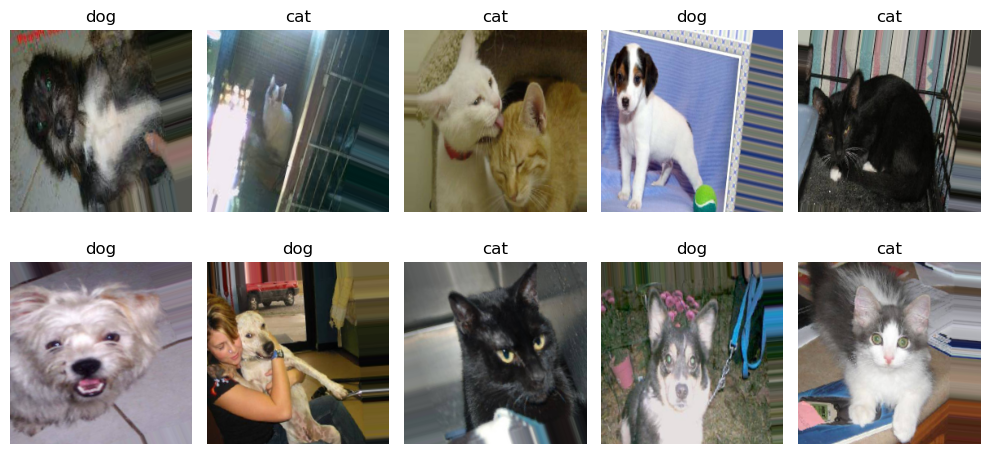

Found 2000 images belonging to 2 classes.


In [4]:
# Load and print example images
def plot_images(generator, class_names, num_cols=5):
    num_rows = 2  # Two rows of images
    plt.figure(figsize=(10, 5))
    for i in range(num_rows):
        batch = generator.next()
        for j in range(num_cols):
            image = batch[0][j]
            label_index = np.argmax(batch[1][j])
            plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
            plt.imshow(image)
            plt.title(f'{class_names[label_index]}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['cat', 'dog']

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


# Visualize a few training images
plot_images(train_generator,class_names)


'''
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
'''

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)




In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


In [6]:
#Defining depthwise and pointwise convolution block
def depthwise_pointwise_block(x, filters, strides):
    x = DepthwiseConv2D((3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x


In [7]:
#Bulding the MobileNet block
def build_mobilenet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = depthwise_pointwise_block(x, 64, (1, 1))
    x = depthwise_pointwise_block(x, 128, (2, 2))
    x = depthwise_pointwise_block(x, 128, (1, 1))
    x = depthwise_pointwise_block(x, 256, (2, 2))
    x = depthwise_pointwise_block(x, 256, (1, 1))
    x = depthwise_pointwise_block(x, 512, (2, 2))

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model


In [8]:
input_shape = (224, 224, 3)
num_classes = 2

model = build_mobilenet(input_shape, num_classes)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128   

In [9]:
len(train_generator)

250

In [10]:
len(test_generator)

63

In [11]:
# Train the model
MobileNet = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


Epoch 1/10
250/250 [==============================] - 1208s 5s/step - loss: 0.6520 - accuracy: 0.6263 - val_loss: 0.7749 - val_accuracy: 0.5000
Epoch 2/10
250/250 [==============================] - 665s 3s/step - loss: 0.5934 - accuracy: 0.6799 - val_loss: 1.4249 - val_accuracy: 0.5000
Epoch 3/10
250/250 [==============================] - 730s 3s/step - loss: 0.5589 - accuracy: 0.7116 - val_loss: 0.7514 - val_accuracy: 0.6285
Epoch 4/10
250/250 [==============================] - 775s 3s/step - loss: 0.5338 - accuracy: 0.7368 - val_loss: 0.6117 - val_accuracy: 0.7010
Epoch 5/10
250/250 [==============================] - 808s 3s/step - loss: 0.4988 - accuracy: 0.7529 - val_loss: 0.6001 - val_accuracy: 0.6925
Epoch 6/10
250/250 [==============================] - 784s 3s/step - loss: 0.4760 - accuracy: 0.7725 - val_loss: 0.8211 - val_accuracy: 0.7110
Epoch 7/10
250/250 [==============================] - 838s 3s/step - loss: 0.4399 - accuracy: 0.7940 - val_loss: 0.4575 - val_accuracy: 0.772

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_accuracy)


63/63 [==============================] - 18s 280ms/step - loss: 0.4012 - accuracy: 0.8190
Test accuracy: 0.8190000057220459


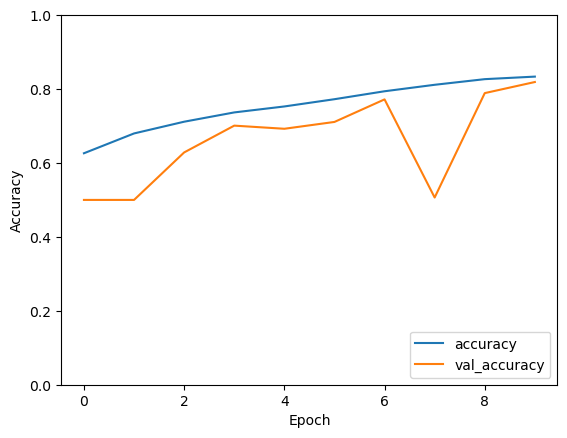

In [13]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(MobileNet.history['accuracy'], label='accuracy')
plt.plot(MobileNet.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 40ms/step
[[0.99442595 0.00625964]]
Image: cat.944.jpg | Predicted Class: cat


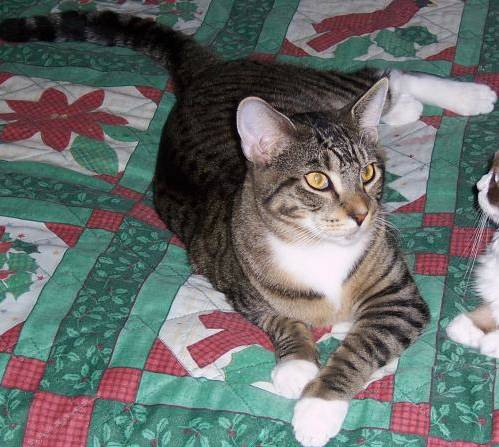

1/1 [==============================] - 0s 34ms/step
[[0.9989154  0.00140507]]
Image: dog.1009.jpg | Predicted Class: cat


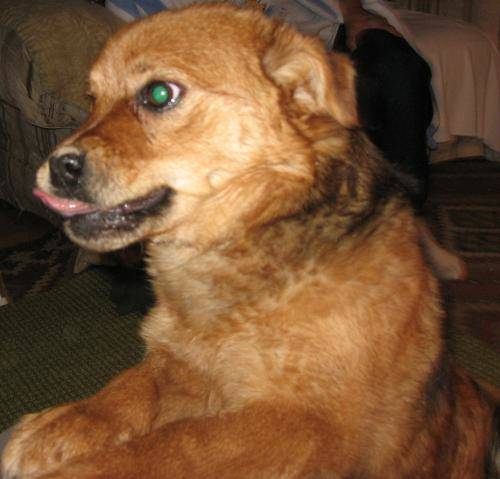

1/1 [==============================] - 0s 23ms/step
[[0.9518237  0.05021207]]
Image: dog.1007.jpg | Predicted Class: cat


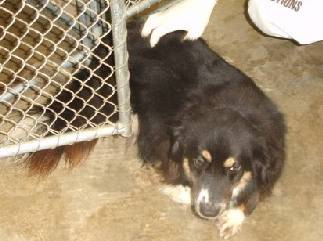

1/1 [==============================] - 0s 51ms/step
[[0.47315517 0.51064926]]
Image: cat.997.jpg | Predicted Class: dog


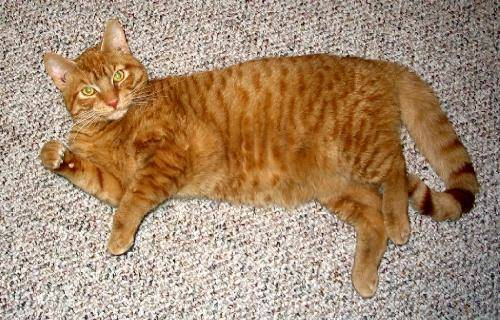

1/1 [==============================] - 0s 36ms/step
[[0.86627084 0.1488676 ]]
Image: cat.943.jpg | Predicted Class: cat


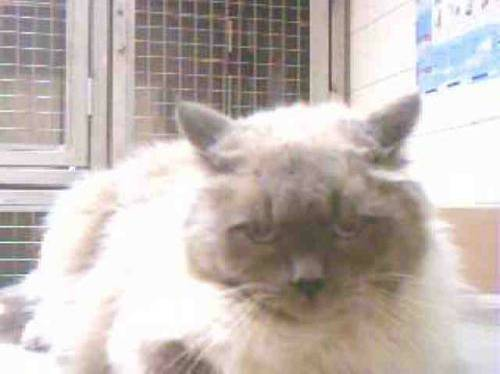

1/1 [==============================] - 0s 33ms/step
[[9.9964893e-01 4.5678637e-04]]
Image: cat.99.jpg | Predicted Class: cat


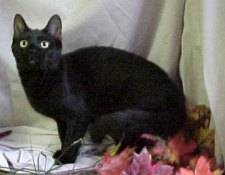

1/1 [==============================] - 0s 25ms/step
[[0.87674844 0.13155974]]
Image: dog.1018.jpg | Predicted Class: cat


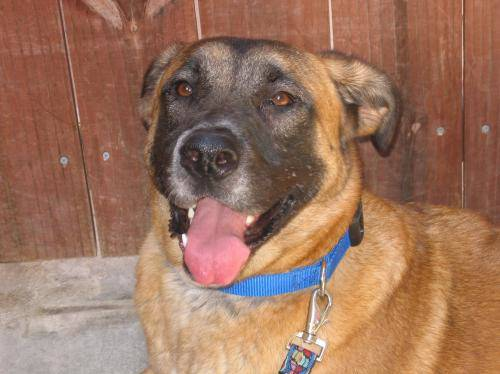

1/1 [==============================] - 0s 41ms/step
[[0.99883795 0.00159648]]
Image: dog.1012.jpg | Predicted Class: cat


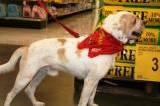

1/1 [==============================] - 0s 42ms/step
[[9.9997425e-01 3.6546084e-05]]
Image: cat.958.jpg | Predicted Class: cat


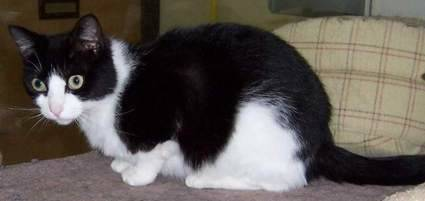

1/1 [==============================] - 0s 39ms/step
[[0.9963526  0.00449974]]
Image: cat.942.jpg | Predicted Class: cat


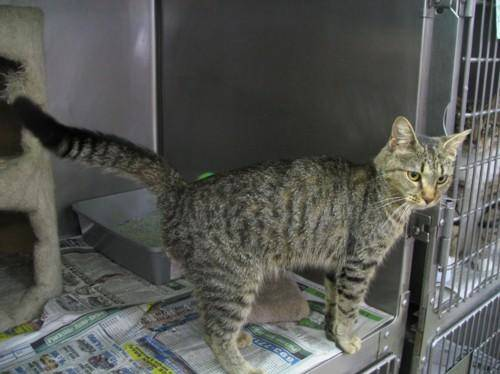

1/1 [==============================] - 0s 35ms/step
[[0.99859345 0.00175859]]
Image: dog.1026.jpg | Predicted Class: cat


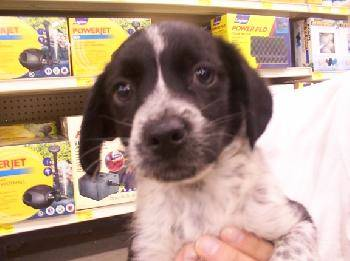

1/1 [==============================] - 0s 22ms/step
[[0.97149235 0.03108856]]
Image: dog.1005.jpg | Predicted Class: cat


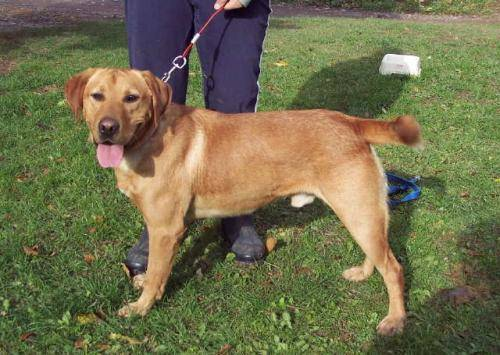

1/1 [==============================] - 0s 50ms/step
[[9.995587e-01 4.807711e-04]]
Image: cat.941.jpg | Predicted Class: cat


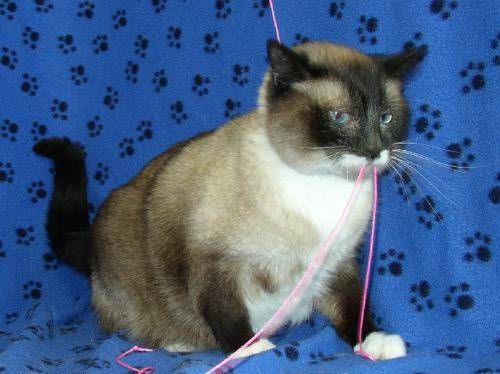

1/1 [==============================] - 0s 37ms/step
[[9.9972421e-01 3.9211762e-04]]
Image: dog.1027.jpg | Predicted Class: cat


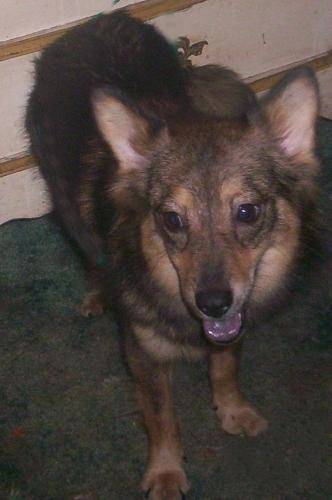

1/1 [==============================] - 0s 39ms/step
[[0.9983171  0.00212892]]
Image: dog.1022.jpg | Predicted Class: cat


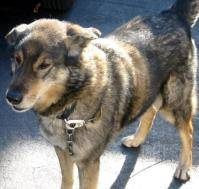

1/1 [==============================] - 0s 33ms/step
[[0.99878716 0.00159499]]
Image: cat.963.jpg | Predicted Class: cat


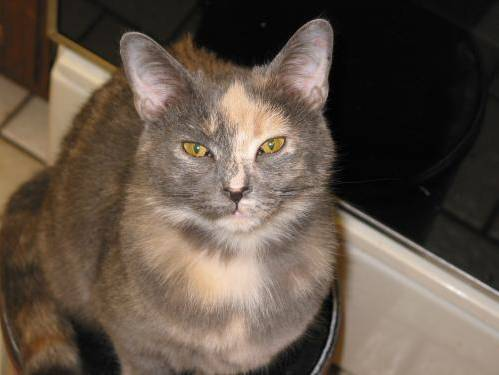

1/1 [==============================] - 0s 48ms/step
[[0.9923258  0.00916628]]
Image: cat.940.jpg | Predicted Class: cat


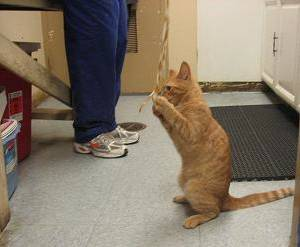

1/1 [==============================] - 0s 42ms/step
[[0.99176425 0.00957357]]
Image: dog.1019.jpg | Predicted Class: cat


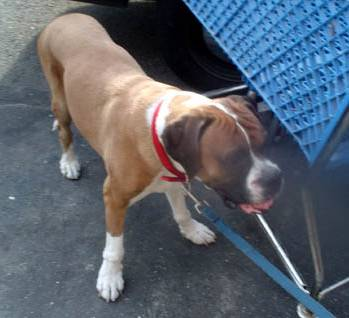

1/1 [==============================] - 0s 50ms/step
[[9.9999982e-01 2.9376616e-07]]
Image: cat.951.jpg | Predicted Class: cat


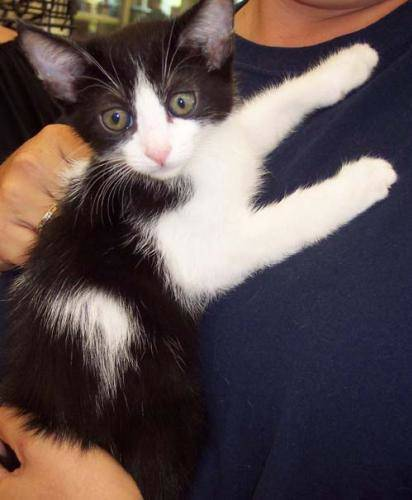

1/1 [==============================] - 0s 34ms/step
[[0.27242798 0.7264188 ]]
Image: dog.1008.jpg | Predicted Class: dog


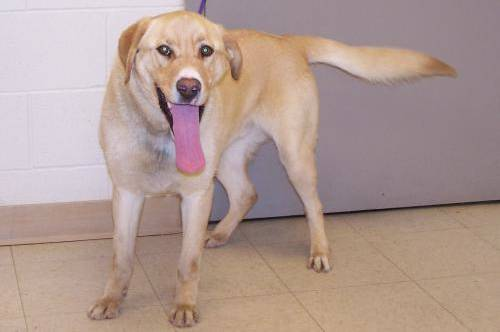

1/1 [==============================] - 0s 39ms/step
[[0.8969613  0.10294734]]
Image: dog.1023.jpg | Predicted Class: cat


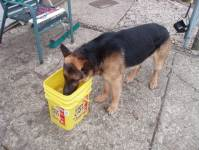

1/1 [==============================] - 0s 39ms/step
[[0.78066677 0.24474166]]
Image: dog.1014.jpg | Predicted Class: cat


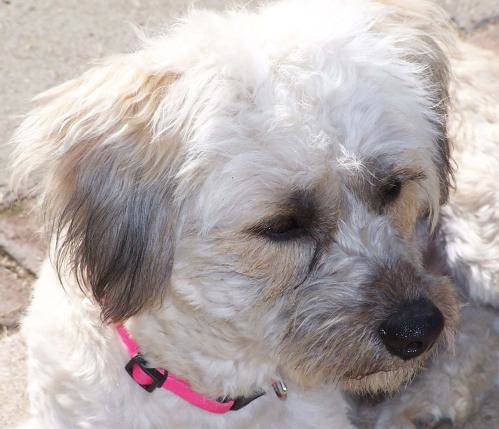

1/1 [==============================] - 0s 39ms/step
[[0.9920323  0.01019605]]
Image: cat.953.jpg | Predicted Class: cat


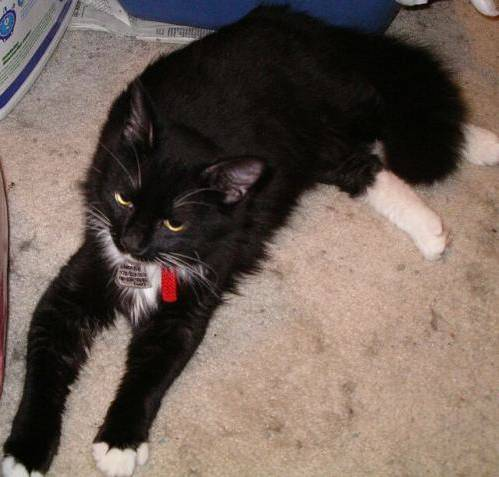

1/1 [==============================] - 0s 32ms/step
[[0.9756475  0.02713952]]
Image: cat.945.jpg | Predicted Class: cat


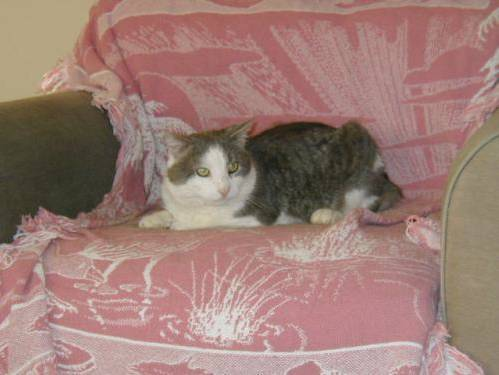

1/1 [==============================] - 0s 34ms/step
[[0.9880211  0.01326273]]
Image: cat.967.jpg | Predicted Class: cat


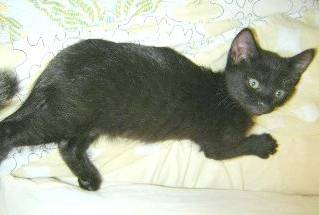

1/1 [==============================] - 0s 38ms/step
[[9.993547e-01 7.691156e-04]]
Image: cat.999.jpg | Predicted Class: cat


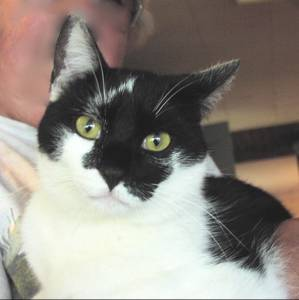

1/1 [==============================] - 0s 30ms/step
[[9.9979967e-01 2.8226111e-04]]
Image: dog.1024.jpg | Predicted Class: cat


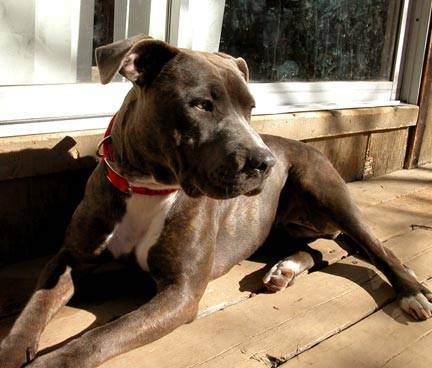

1/1 [==============================] - 0s 38ms/step
[[9.9981368e-01 2.4252702e-04]]
Image: cat.961.jpg | Predicted Class: cat


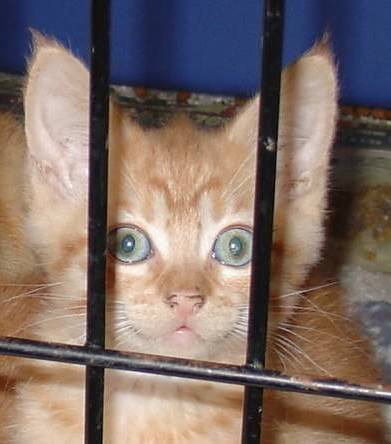

1/1 [==============================] - 0s 37ms/step
[[9.997659e-01 3.188268e-04]]
Image: dog.1004.jpg | Predicted Class: cat


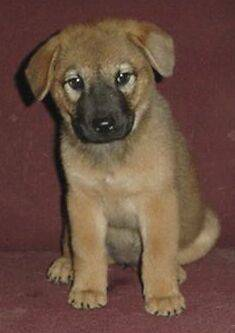

1/1 [==============================] - 0s 72ms/step
[[0.9734124  0.02993032]]
Image: cat.97.jpg | Predicted Class: cat


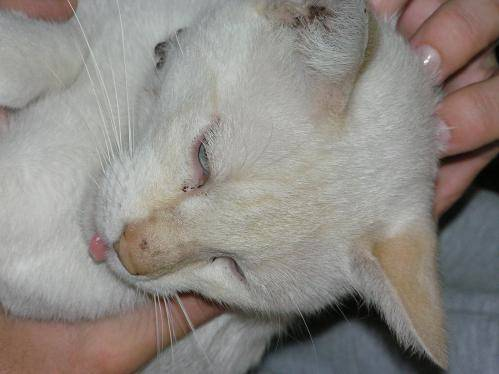

1/1 [==============================] - 0s 38ms/step
[[0.9983919  0.00199036]]
Image: cat.98.jpg | Predicted Class: cat


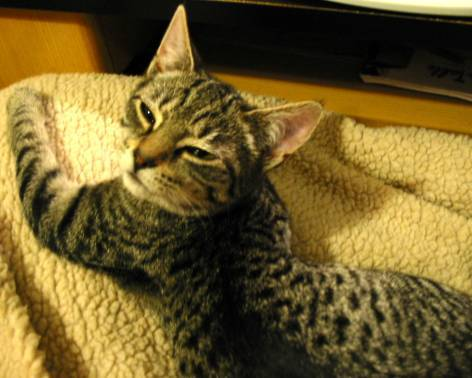

1/1 [==============================] - 0s 36ms/step
[[0.99188566 0.00959256]]
Image: dog.1025.jpg | Predicted Class: cat


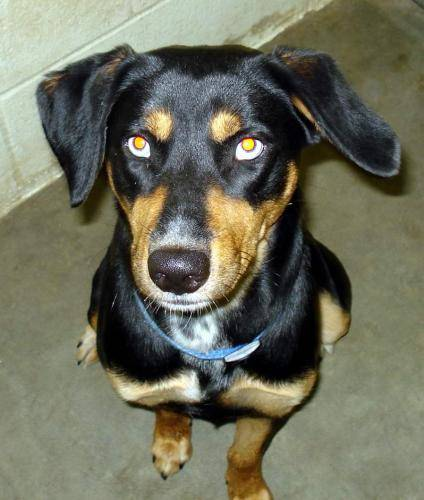

1/1 [==============================] - 0s 38ms/step
[[9.998756e-01 1.818613e-04]]
Image: cat.95.jpg | Predicted Class: cat


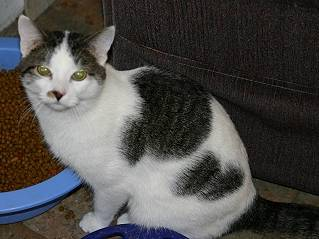

1/1 [==============================] - 0s 52ms/step
[[9.994169e-01 7.917114e-04]]
Image: cat.952.jpg | Predicted Class: cat


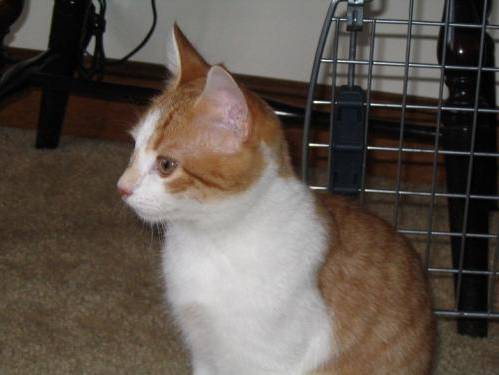

1/1 [==============================] - 0s 51ms/step
[[0.9978422  0.00283459]]
Image: cat.954.jpg | Predicted Class: cat


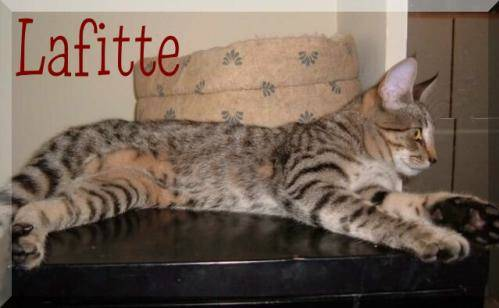

1/1 [==============================] - 0s 43ms/step
[[0.97362024 0.029983  ]]
Image: dog.1010.jpg | Predicted Class: cat


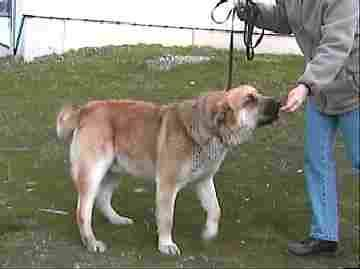

1/1 [==============================] - 0s 34ms/step
[[0.98516035 0.01820093]]
Image: cat.966.jpg | Predicted Class: cat


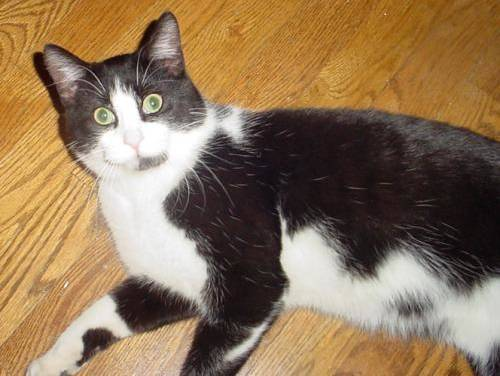

1/1 [==============================] - 0s 43ms/step
[[0.99714553 0.00353834]]
Image: cat.962.jpg | Predicted Class: cat


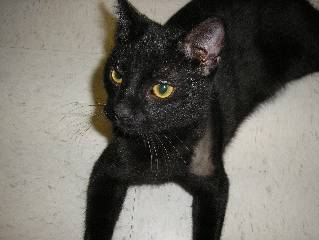

1/1 [==============================] - 0s 57ms/step
[[9.995913e-01 5.683348e-04]]
Image: dog.1016.jpg | Predicted Class: cat


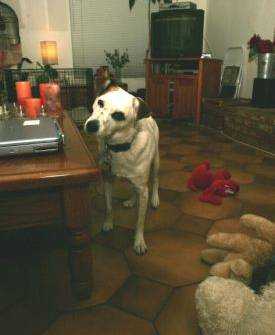

1/1 [==============================] - 0s 42ms/step
[[0.9840322  0.01637473]]
Image: dog.1015.jpg | Predicted Class: cat


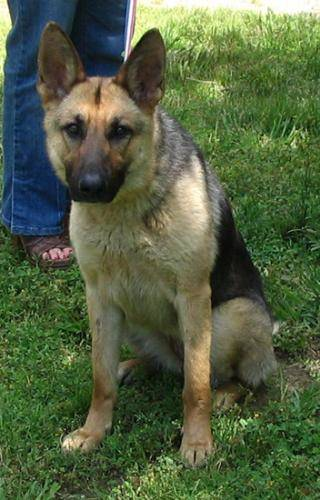

1/1 [==============================] - 0s 48ms/step
[[0.99531543 0.00567811]]
Image: dog.1020.jpg | Predicted Class: cat


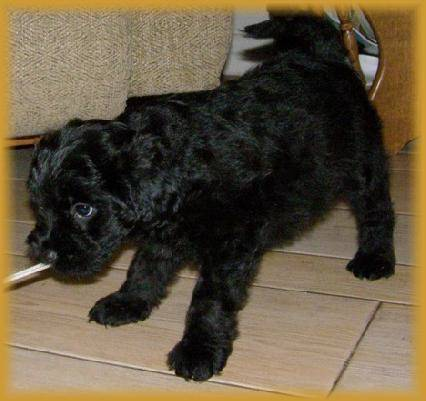

1/1 [==============================] - 0s 39ms/step
[[9.999518e-01 6.885861e-05]]
Image: dog.1017.jpg | Predicted Class: cat


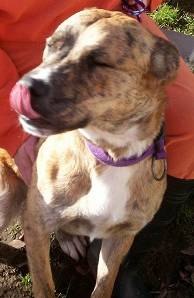

1/1 [==============================] - 0s 29ms/step
[[0.9940319  0.00729223]]
Image: dog.1011.jpg | Predicted Class: cat


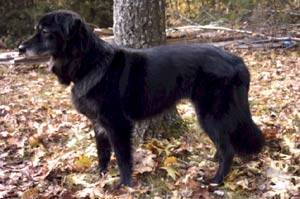

1/1 [==============================] - 0s 37ms/step
[[0.6796759 0.2768607]]
Image: dog.1013.jpg | Predicted Class: cat


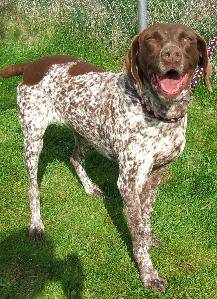

1/1 [==============================] - 0s 41ms/step
[[0.998017   0.00294023]]
Image: dog.1006.jpg | Predicted Class: cat


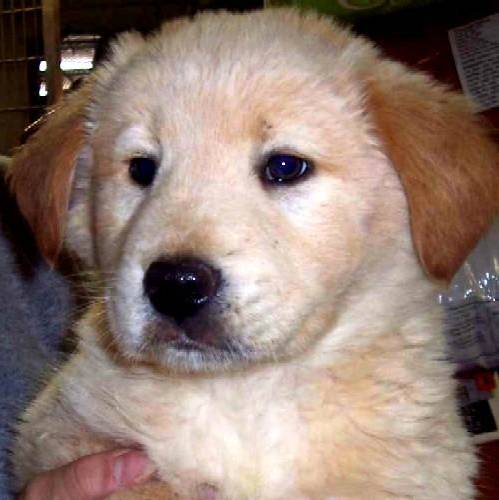

1/1 [==============================] - 0s 43ms/step
[[0.998854   0.00143259]]
Image: cat.949.jpg | Predicted Class: cat


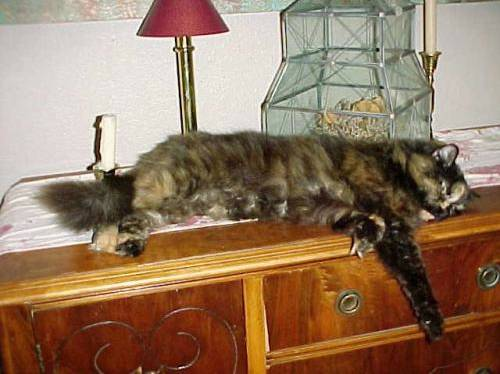

1/1 [==============================] - 0s 40ms/step
[[9.9993145e-01 1.0302105e-04]]
Image: cat.964.jpg | Predicted Class: cat


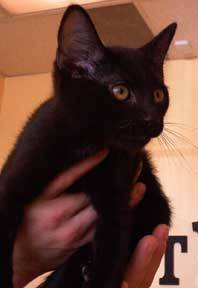

1/1 [==============================] - 0s 36ms/step
[[9.993415e-01 8.591837e-04]]
Image: cat.968.jpg | Predicted Class: cat


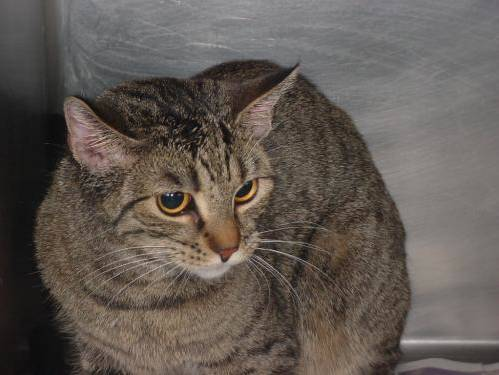

1/1 [==============================] - 0s 49ms/step
[[9.9979448e-01 2.9237964e-04]]
Image: cat.957.jpg | Predicted Class: cat


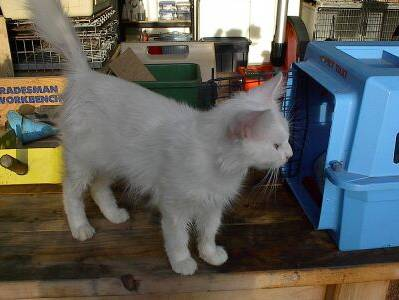

1/1 [==============================] - 0s 43ms/step
[[0.99897695 0.00131515]]
Image: cat.959.jpg | Predicted Class: cat


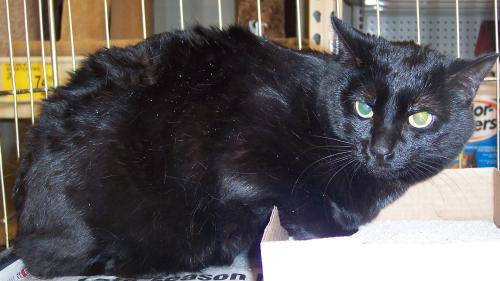

1/1 [==============================] - 0s 24ms/step
[[0.9840592  0.01880112]]
Image: cat.998.jpg | Predicted Class: cat


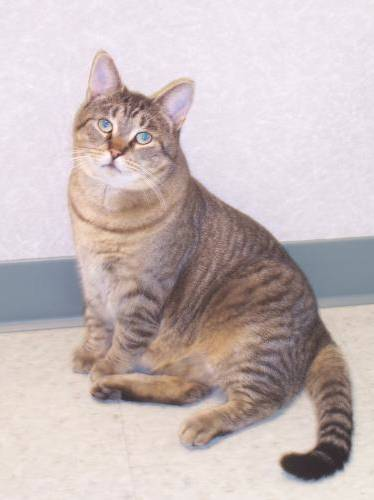

1/1 [==============================] - 0s 41ms/step
[[9.9966365e-01 4.2489593e-04]]
Image: cat.955.jpg | Predicted Class: cat


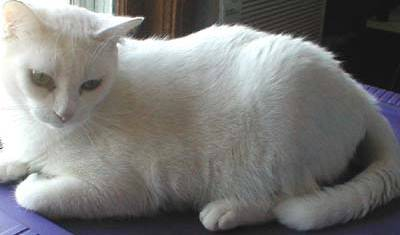

1/1 [==============================] - 0s 32ms/step
[[0.99398726 0.00728027]]
Image: dog.1021.jpg | Predicted Class: cat


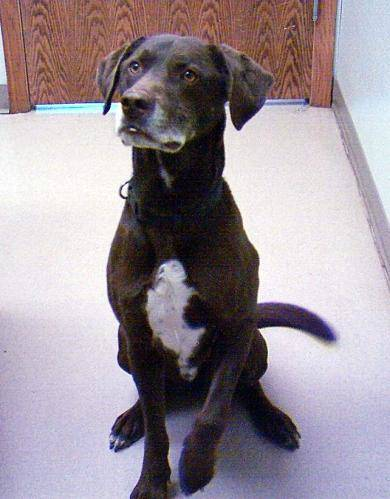

1/1 [==============================] - 0s 33ms/step
[[9.991898e-01 9.887514e-04]]
Image: dog.1028.jpg | Predicted Class: cat


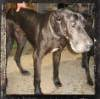

1/1 [==============================] - 0s 47ms/step
[[0.9970854  0.00350869]]
Image: cat.948.jpg | Predicted Class: cat


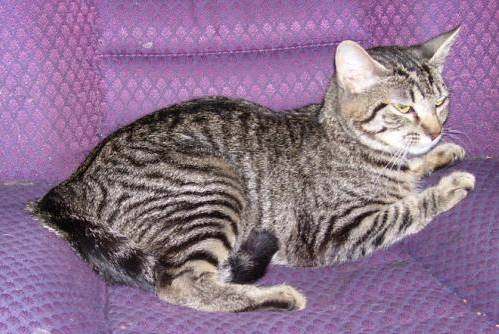

1/1 [==============================] - 0s 43ms/step
[[0.95939225 0.04502866]]
Image: cat.965.jpg | Predicted Class: cat


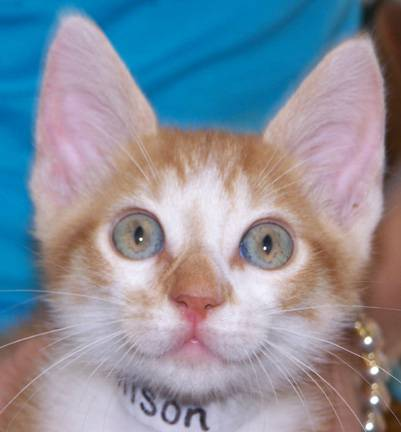

1/1 [==============================] - 0s 40ms/step
[[0.99880147 0.0015026 ]]
Image: cat.946.jpg | Predicted Class: cat


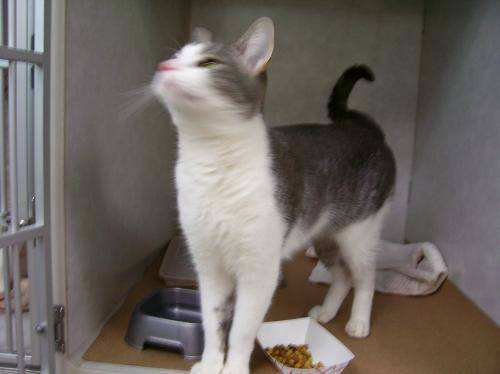

1/1 [==============================] - 0s 40ms/step
[[9.998179e-01 2.581836e-04]]
Image: cat.960.jpg | Predicted Class: cat


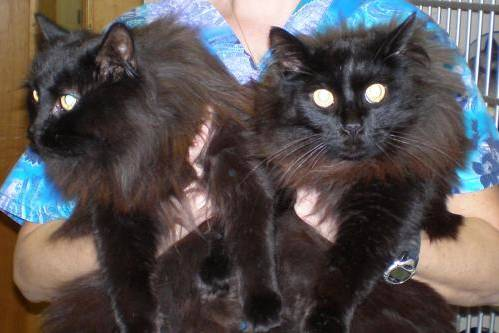

1/1 [==============================] - 0s 48ms/step
[[0.98115146 0.02043232]]
Image: cat.96.jpg | Predicted Class: cat


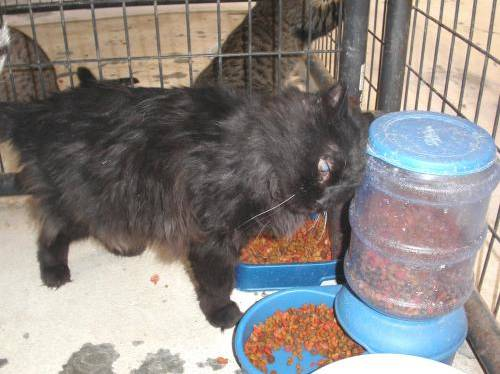

1/1 [==============================] - 0s 37ms/step
[[0.9441988  0.05881698]]
Image: dog.1029.jpg | Predicted Class: cat


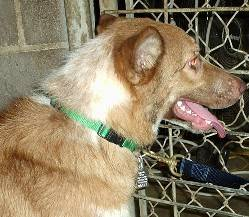

1/1 [==============================] - 0s 25ms/step
[[9.9947125e-01 6.1398133e-04]]
Image: cat.956.jpg | Predicted Class: cat


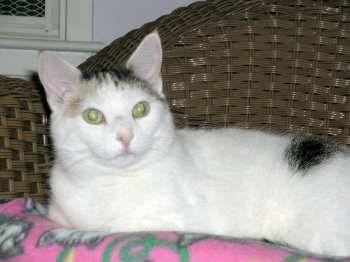

1/1 [==============================] - 0s 43ms/step
[[0.9944721 0.0062153]]
Image: cat.947.jpg | Predicted Class: cat


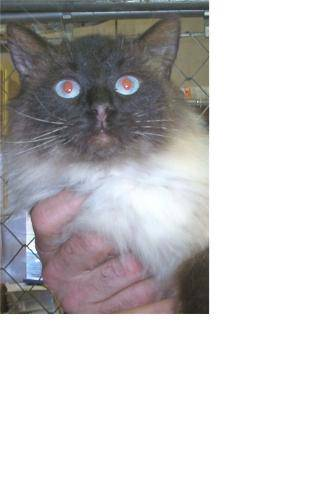

1/1 [==============================] - 0s 29ms/step
[[0.9988421  0.00147664]]
Image: cat.950.jpg | Predicted Class: cat


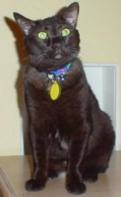

In [47]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image, display
import random

# Load your trained MobileNet model
#model = 

# Define a function to preprocess an image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224,3))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Folder containing prediction images
prediction_folder = "cats-dogs"

# List all image files in the folder
#image_files = [f for f in os.listdir(prediction_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

random.shuffle(image_files)

# Make predictions for each image
for image_file in image_files:
    image_path = os.path.join(prediction_folder, image_file)
    processed_image = preprocess_image(image_path)
    predictions = model.predict(processed_image)
    print(predictions)
    predicted_class = np.argmax(predictions[0])  # Get the index of the class with the highest probability

    # Assuming your classes are ["cat", "dog"]
    if predicted_class == 0:
        predicted_label = "cat"
    else:
        predicted_label = "dog"

    print(f"Image: {image_file} | Predicted Class: {predicted_label}")
    
     # Display the image
    display(Image(filename=image_path))


In [64]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('cats-dogs/cat.947.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
train_generator.class_indices
if result[0][0] == 1:
  prediction = 'dog'
else:
  prediction = 'cat'

1/1 [==============================] - 0s 28ms/step
[[1. 0.]]


In [65]:
print(prediction)

dog


1/1 [==============================] - 0s 34ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: cat.951.jpg | Predicted Class: dog


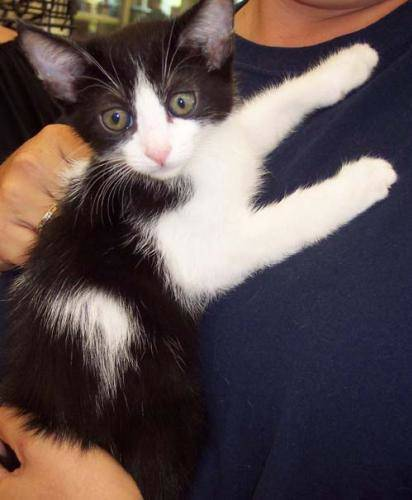

1/1 [==============================] - 0s 41ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: dog.1013.jpg | Predicted Class: dog


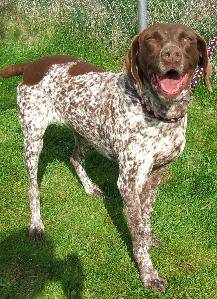

1/1 [==============================] - 0s 39ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1006.jpg | Predicted Class: cat


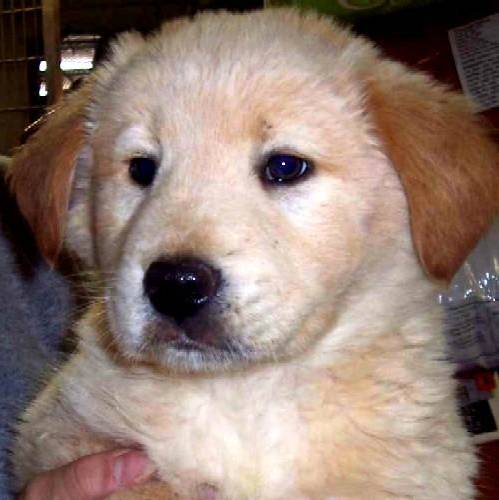

1/1 [==============================] - 0s 41ms/step
[[99.99  0.  ]]
{'cats': 0, 'dogs': 1}
Image: cat.952.jpg | Predicted Class: cat


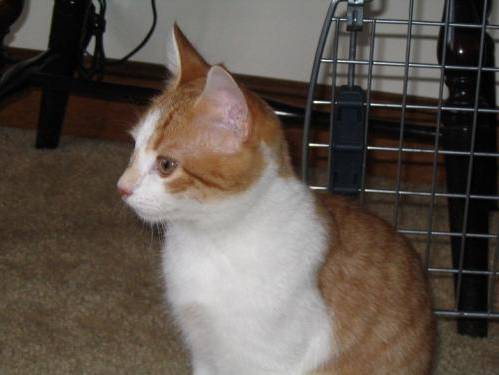

1/1 [==============================] - 0s 42ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1012.jpg | Predicted Class: cat


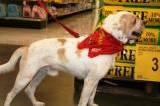

1/1 [==============================] - 0s 29ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.958.jpg | Predicted Class: cat


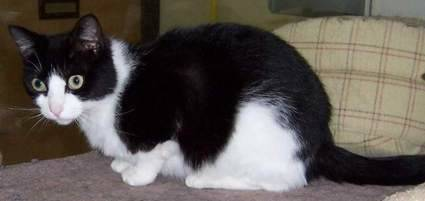

1/1 [==============================] - 0s 56ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: cat.949.jpg | Predicted Class: dog


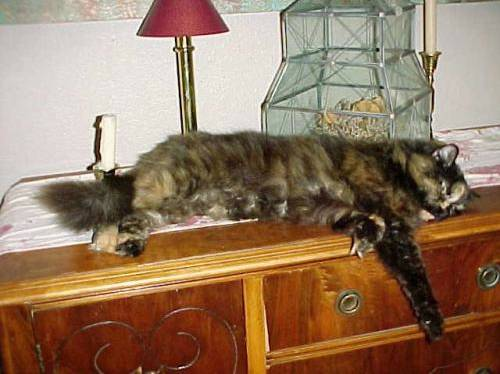

1/1 [==============================] - 0s 42ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1007.jpg | Predicted Class: cat


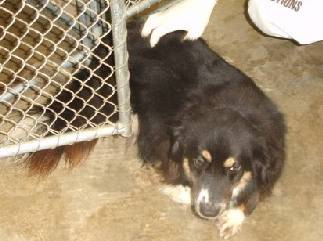

1/1 [==============================] - 0s 39ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.97.jpg | Predicted Class: cat


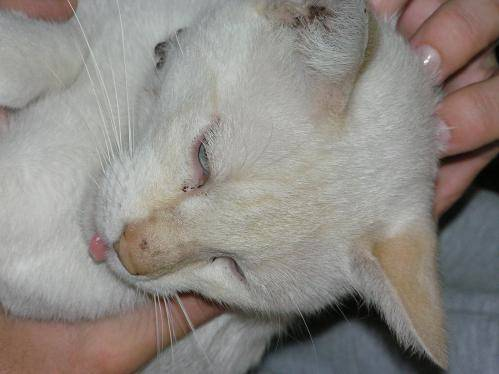

1/1 [==============================] - 0s 32ms/step
[[48.71  0.  ]]
{'cats': 0, 'dogs': 1}
Image: cat.95.jpg | Predicted Class: dog


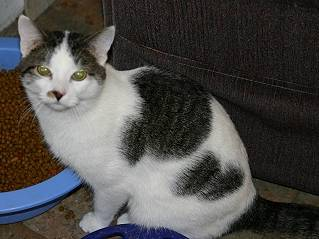

1/1 [==============================] - 0s 79ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: cat.98.jpg | Predicted Class: dog


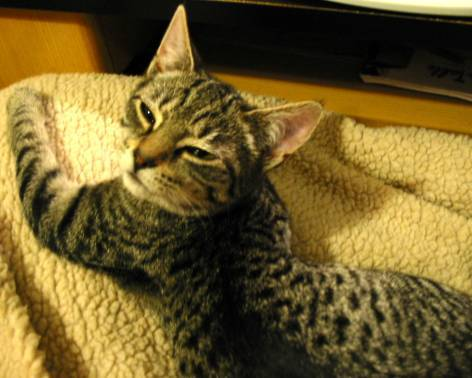

1/1 [==============================] - 0s 40ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1014.jpg | Predicted Class: cat


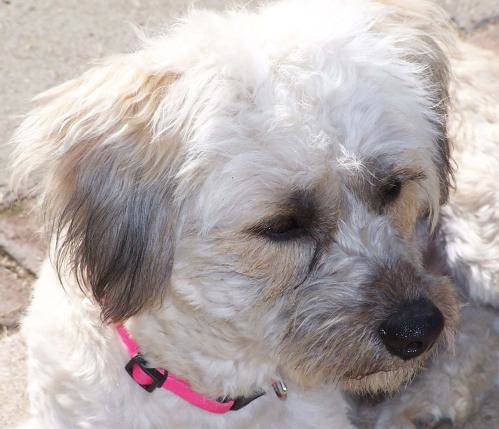

1/1 [==============================] - 0s 34ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.997.jpg | Predicted Class: cat


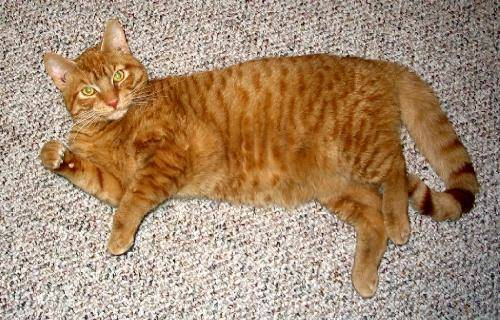

1/1 [==============================] - 0s 34ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.963.jpg | Predicted Class: cat


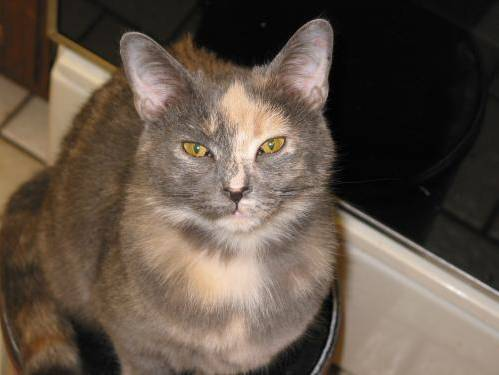

1/1 [==============================] - 0s 32ms/step
[[0.  0.2]]
{'cats': 0, 'dogs': 1}
Image: cat.960.jpg | Predicted Class: dog


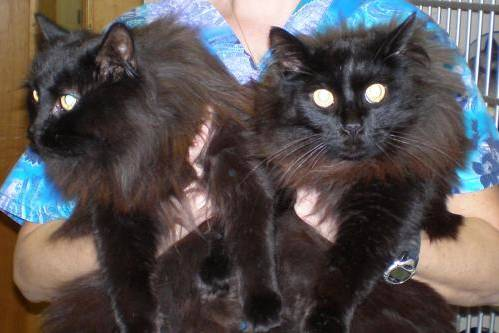

1/1 [==============================] - 0s 27ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.961.jpg | Predicted Class: cat


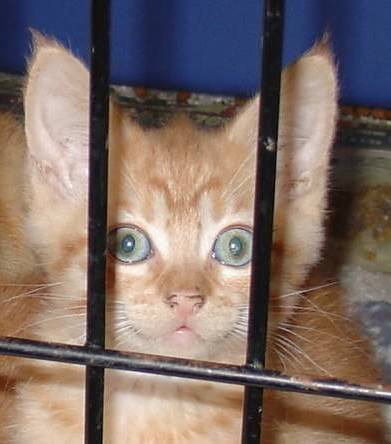

1/1 [==============================] - 0s 28ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1020.jpg | Predicted Class: cat


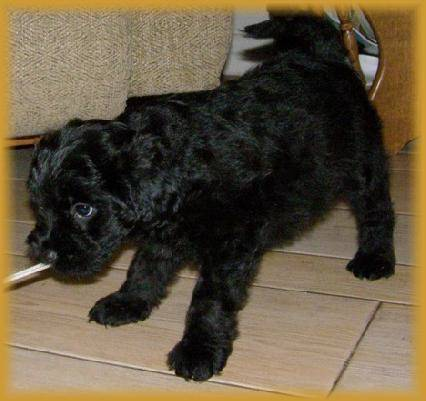

1/1 [==============================] - 0s 66ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.962.jpg | Predicted Class: cat


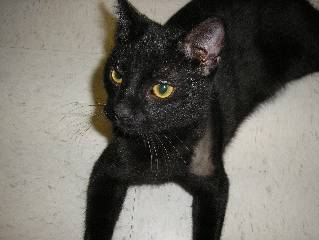

1/1 [==============================] - 0s 36ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.942.jpg | Predicted Class: cat


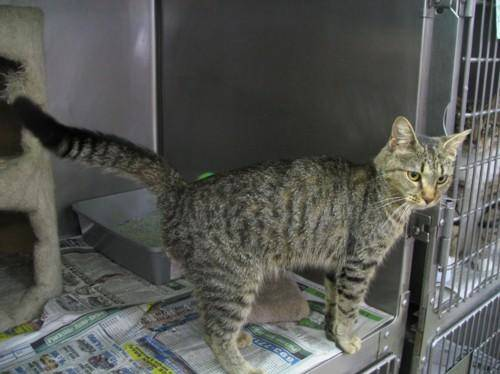

1/1 [==============================] - 0s 47ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.943.jpg | Predicted Class: cat


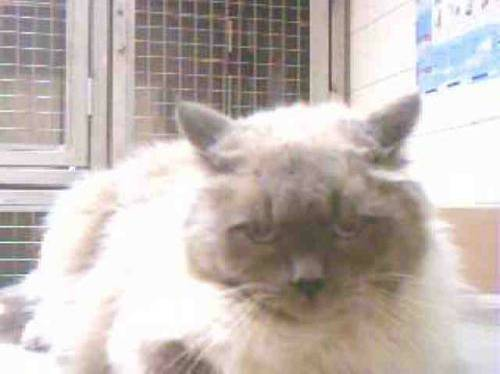

1/1 [==============================] - 0s 44ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1021.jpg | Predicted Class: cat


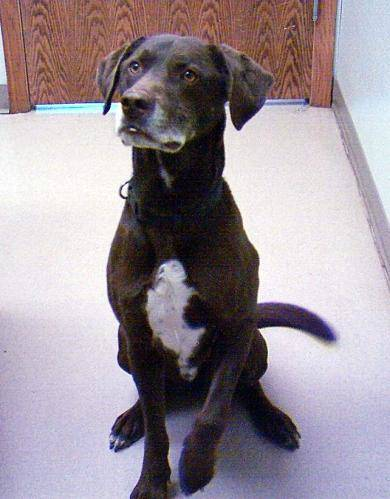

1/1 [==============================] - 0s 60ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1008.jpg | Predicted Class: cat


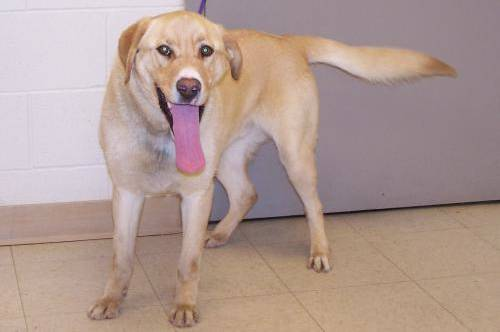

1/1 [==============================] - 0s 40ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.956.jpg | Predicted Class: cat


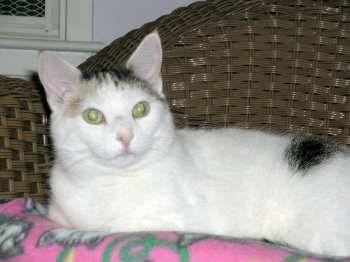

1/1 [==============================] - 0s 40ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: cat.954.jpg | Predicted Class: dog


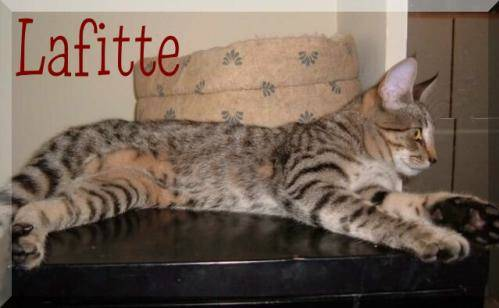

1/1 [==============================] - 0s 48ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1022.jpg | Predicted Class: cat


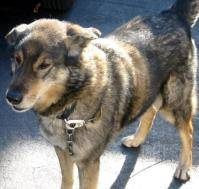

1/1 [==============================] - 0s 67ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.965.jpg | Predicted Class: cat


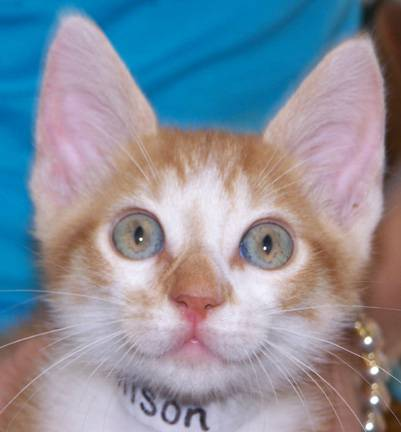

1/1 [==============================] - 0s 39ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.99.jpg | Predicted Class: cat


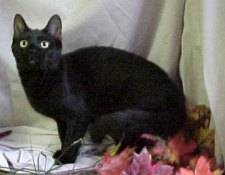

1/1 [==============================] - 0s 34ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.944.jpg | Predicted Class: cat


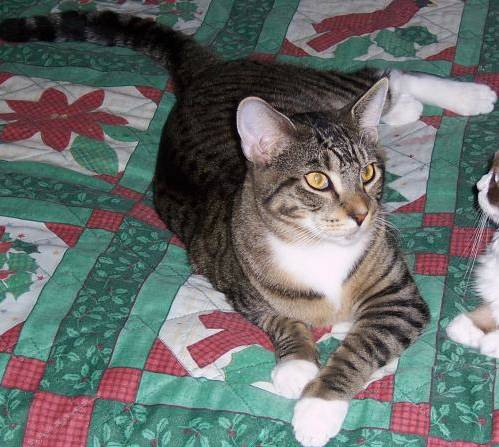

1/1 [==============================] - 0s 34ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.967.jpg | Predicted Class: cat


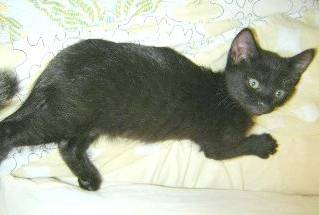

1/1 [==============================] - 0s 44ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: dog.1027.jpg | Predicted Class: dog


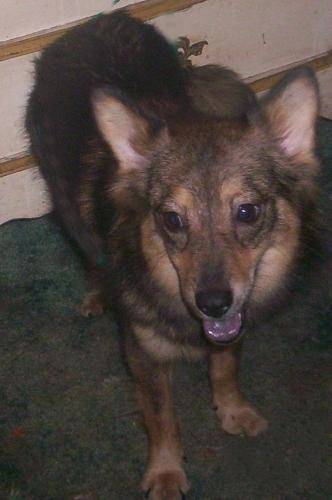

1/1 [==============================] - 0s 39ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.96.jpg | Predicted Class: cat


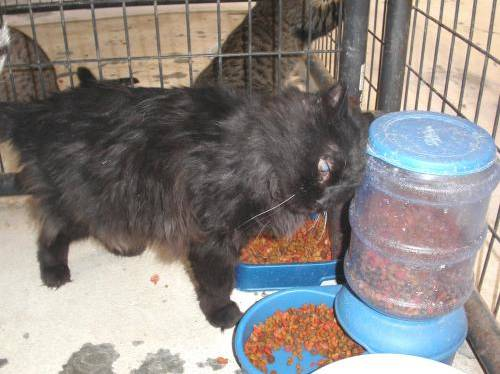

1/1 [==============================] - 0s 43ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.959.jpg | Predicted Class: cat


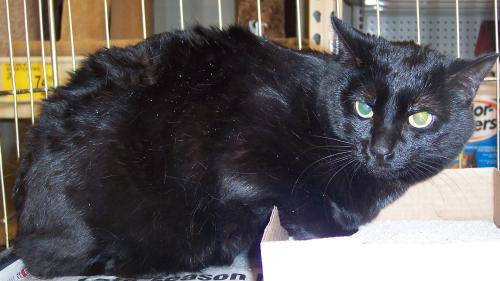

1/1 [==============================] - 0s 43ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.955.jpg | Predicted Class: cat


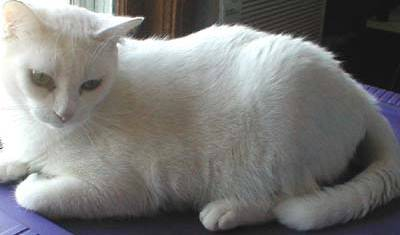

1/1 [==============================] - 0s 71ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.946.jpg | Predicted Class: cat


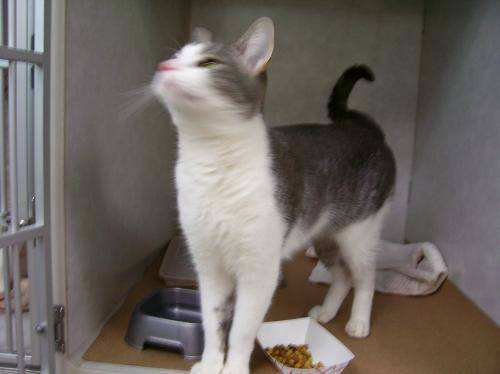

1/1 [==============================] - 0s 40ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.945.jpg | Predicted Class: cat


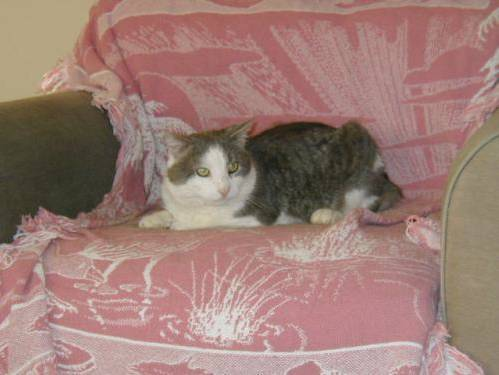

1/1 [==============================] - 0s 78ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1029.jpg | Predicted Class: cat


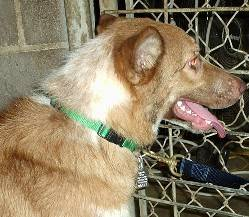

1/1 [==============================] - 0s 41ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1023.jpg | Predicted Class: cat


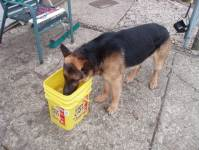

1/1 [==============================] - 0s 38ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.948.jpg | Predicted Class: cat


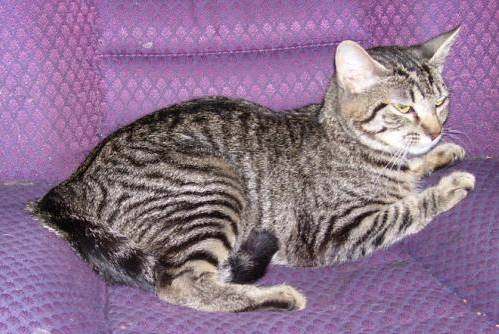

1/1 [==============================] - 0s 40ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.941.jpg | Predicted Class: cat


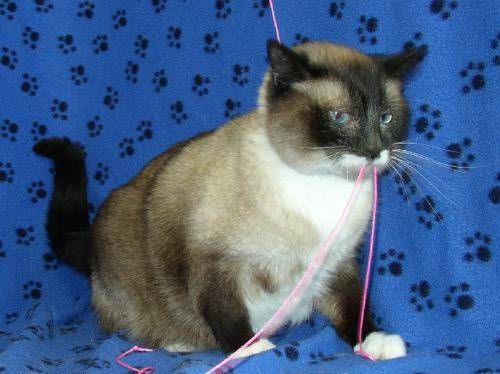

1/1 [==============================] - 0s 45ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: cat.964.jpg | Predicted Class: dog


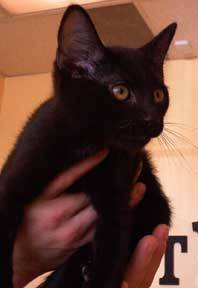

1/1 [==============================] - 0s 38ms/step
[[60.98  0.  ]]
{'cats': 0, 'dogs': 1}
Image: cat.968.jpg | Predicted Class: cat


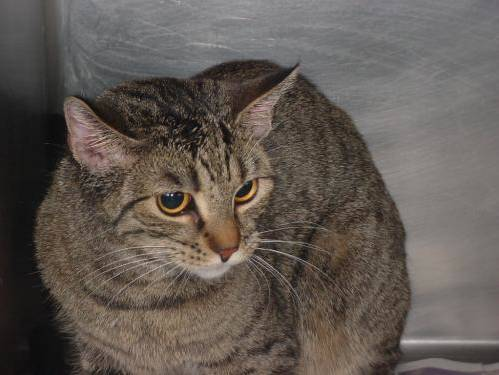

1/1 [==============================] - 0s 60ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: dog.1028.jpg | Predicted Class: dog


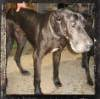

1/1 [==============================] - 0s 47ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.953.jpg | Predicted Class: cat


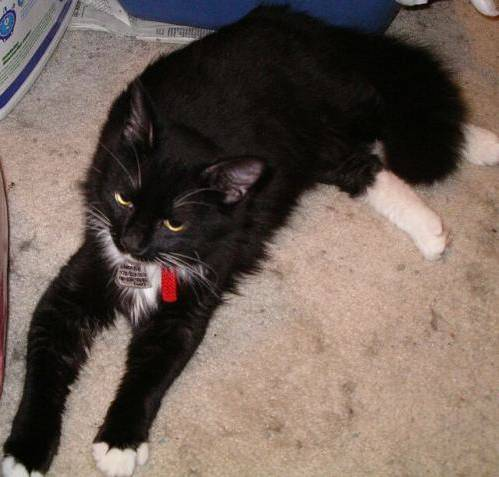

1/1 [==============================] - 0s 70ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1018.jpg | Predicted Class: cat


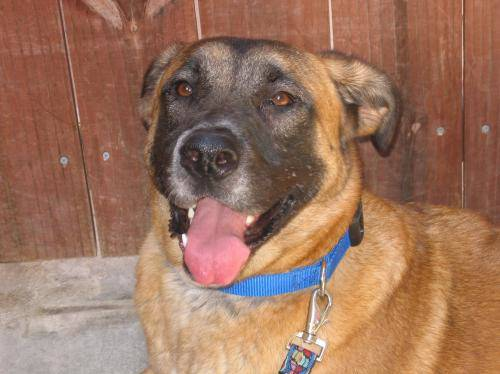

1/1 [==============================] - 0s 52ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.940.jpg | Predicted Class: cat


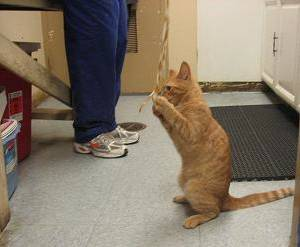

1/1 [==============================] - 0s 45ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: dog.1015.jpg | Predicted Class: dog


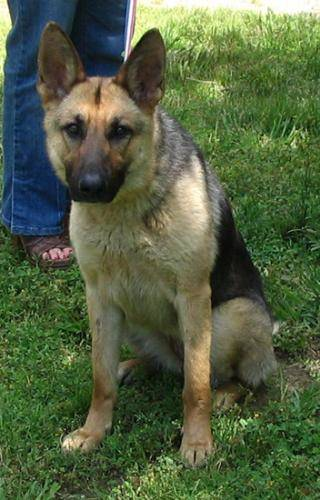

1/1 [==============================] - 0s 68ms/step
[[97.51  0.  ]]
{'cats': 0, 'dogs': 1}
Image: dog.1010.jpg | Predicted Class: cat


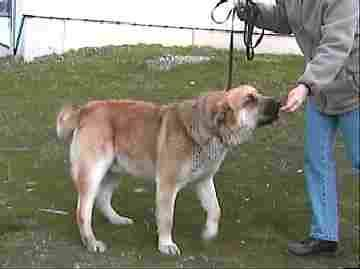

1/1 [==============================] - 0s 32ms/step
[[0.01 5.99]]
{'cats': 0, 'dogs': 1}
Image: dog.1016.jpg | Predicted Class: dog


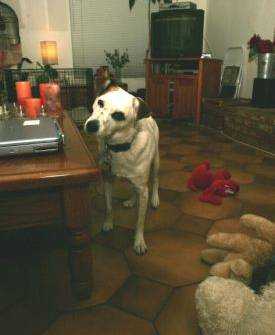

1/1 [==============================] - 0s 30ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.957.jpg | Predicted Class: cat


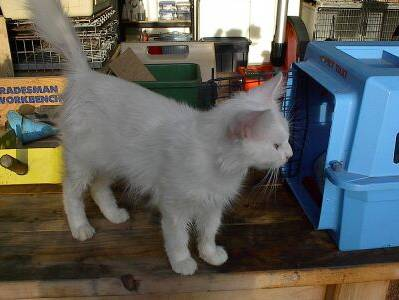

1/1 [==============================] - 0s 54ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1009.jpg | Predicted Class: cat


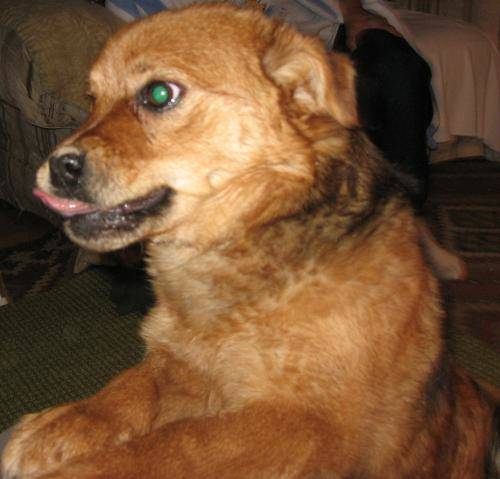

1/1 [==============================] - 0s 47ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.947.jpg | Predicted Class: cat


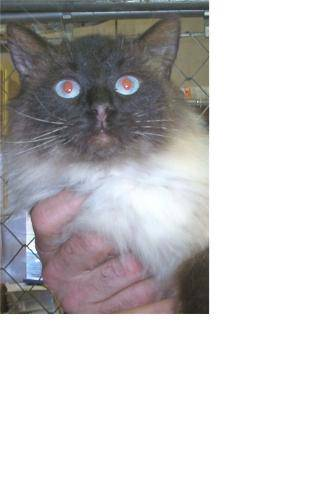

1/1 [==============================] - 0s 66ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.999.jpg | Predicted Class: cat


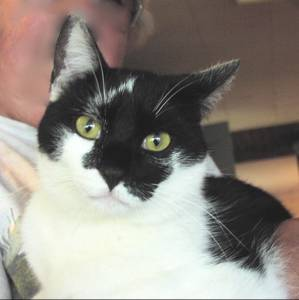

1/1 [==============================] - 0s 45ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1011.jpg | Predicted Class: cat


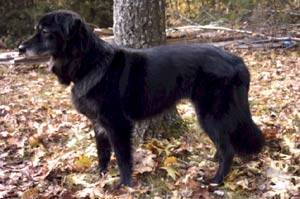

1/1 [==============================] - 0s 54ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: dog.1005.jpg | Predicted Class: dog


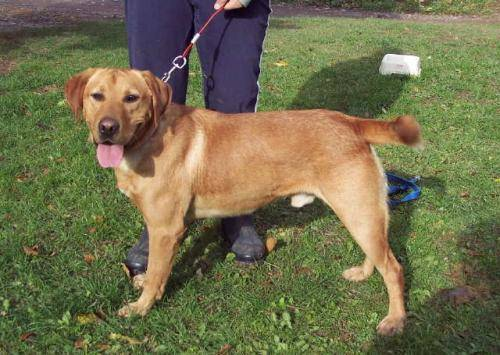

1/1 [==============================] - 0s 62ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: dog.1017.jpg | Predicted Class: dog


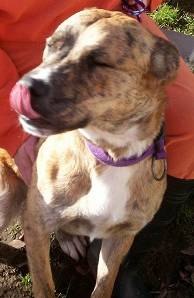

1/1 [==============================] - 0s 79ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: dog.1019.jpg | Predicted Class: dog


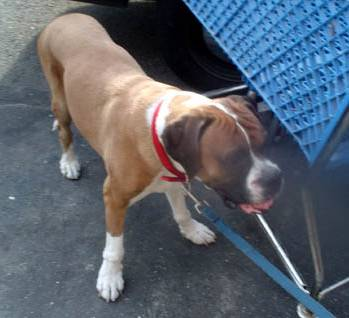

1/1 [==============================] - 0s 30ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.950.jpg | Predicted Class: cat


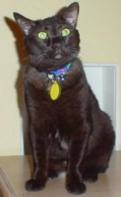

1/1 [==============================] - 0s 29ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1026.jpg | Predicted Class: cat


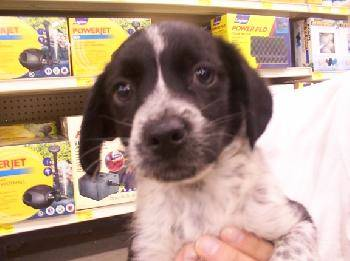

1/1 [==============================] - 0s 47ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.998.jpg | Predicted Class: cat


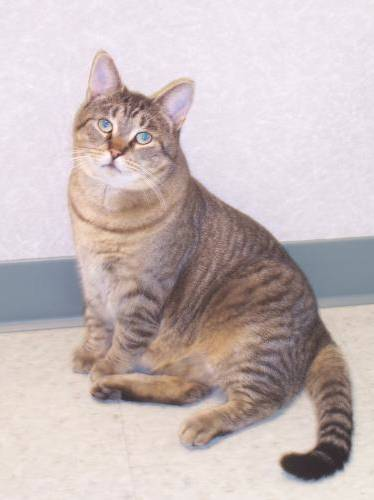

1/1 [==============================] - 0s 48ms/step
[[  0. 100.]]
{'cats': 0, 'dogs': 1}
Image: dog.1025.jpg | Predicted Class: dog


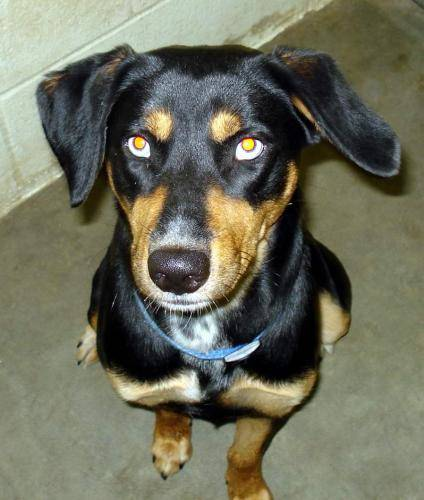

1/1 [==============================] - 0s 34ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: dog.1004.jpg | Predicted Class: cat


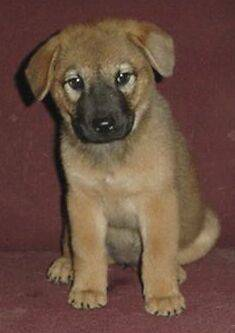

1/1 [==============================] - 0s 34ms/step
[[99.92  0.  ]]
{'cats': 0, 'dogs': 1}
Image: dog.1024.jpg | Predicted Class: cat


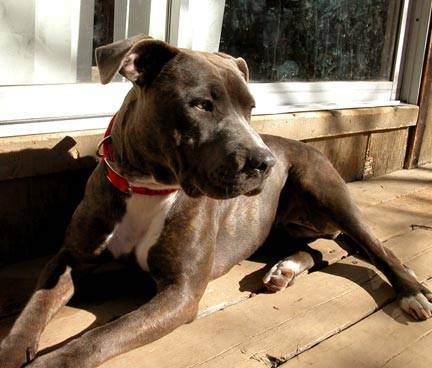

1/1 [==============================] - 0s 32ms/step
[[100.   0.]]
{'cats': 0, 'dogs': 1}
Image: cat.966.jpg | Predicted Class: cat


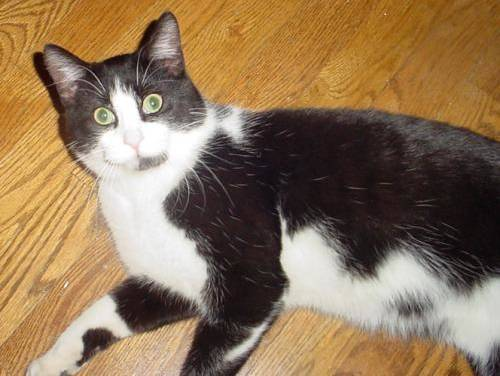

In [103]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os
import random
from IPython.display import Image, display
# Load your trained MobileNet model
# model = ... (Load your model here)

# Path to the folder containing images for prediction
folder_path = "cats-dogs"

# List all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

random.shuffle(image_files)
# Iterate through image files and make predictions
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    
    # Load and preprocess the image
    test_image = image.load_img(image_path, target_size=(224, 224,3))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    
    # Make prediction
    result = model.predict(test_image)
    result_percentages = np.round(result * 100, 2)
    print(result_percentages)
    
    # Get class indices
    class_indices = train_generator.class_indices
    print(class_indices)
    
    # Determine the predicted class label
    if result_percentages[0][0] >= 50:
        predicted_class = 'cat'
    else:
        predicted_class = 'dog'
    
    # Print image file name and predicted class
    print(f"Image: {image_file} | Predicted Class: {predicted_class}")
    
     # Display the image
    display(Image(filename=image_path))
    
    
